In [63]:
import json
import numpy as np
import pandas as pd
import zlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
with open("results/3_0.json", "rb") as f:
    results = json.loads(json.load(f))

In [12]:
Y_train = np.array(results[1])
Y_test = np.array(results[2])
prob_history_oob = np.array(json.loads(zlib.decompress(eval(results[3])).decode().replace("nan", "-1")))
prob_history_val = np.array(json.loads(zlib.decompress(eval(results[4])).decode().replace("nan", "-1")))

num_classes = Y_train.shape[1]

prob_history_oob[prob_history_oob < 0] = np.nan
prob_history_val[prob_history_val < 0] = np.nan

# times
times_fit = results[-4]
times_predict_train = results[-3]
times_predict_val = results[-2]
times_update = results[-1]

In [67]:
def compute_forest_properties(prob_history_oob, prob_history_val, Y_train, Y_val, show_progress=False):
    for key, probs_orig, Y in zip(["oob", "val"], [prob_history_oob, prob_history_val], [Y_train, Y_val]):

        # compute distribution per forest size
        counter = np.zeros((probs_orig.shape[1], probs_orig.shape[2]))  # count how many trees voted on each instance (also use classes for convenience)
        probs_forest = np.zeros(counter.shape)
        probs_forest[:] = np.nan
        prob_vars_forest = np.zeros(counter.shape)
        prob_vars_forest[:] = np.nan
        probs_forests = []
        single_tree_scores = []
        single_tree_scores_mean_ests = []
        single_tree_scores_std_ests = []
        forest_scores = []
        correction_terms = []

        iterable = tqdm(probs_orig) if show_progress else probs_orig
        for t, probs_tree in enumerate(iterable, start=1):
            mask_for_validated_instances = ~np.isnan(probs_tree)[:, 0]
            mask_insert = mask_for_validated_instances & np.isnan(probs_forest)[:, 0]
            mask_update = mask_for_validated_instances & ~np.isnan(probs_forest)[:, 0]
            old_counter = counter.copy()
            counter[mask_for_validated_instances] += 1
            probs_forest[mask_insert] = probs_tree[mask_insert]
            probs_forest[mask_update] = (old_counter[mask_update] * probs_forest[mask_update] + probs_tree[
                mask_update]) / counter[mask_update]
            probs_forests.append(probs_forest.copy())

            # check insertable instances
            mask_for_scatter_insertable_instances = mask_for_validated_instances & (counter[:, 0] == 1)
            prob_vars_forest[mask_for_scatter_insertable_instances, :] = 0

            # compute probability variances
            if t == 1:
                correction_terms.append(0)  # no variance estimate for first tree
            else:
                mask_for_scatter_updateable_instances = mask_for_validated_instances & (counter[:, 0] >= 2)
                previous_scatter = prob_vars_forest[mask_for_scatter_updateable_instances] * old_counter[
                    mask_for_scatter_updateable_instances]
                update_factor1 = probs_tree[mask_for_scatter_updateable_instances] - probs_forests[-2][
                    mask_for_scatter_updateable_instances]
                update_factor2 = probs_tree[mask_for_scatter_updateable_instances] - probs_forests[-1][
                    mask_for_scatter_updateable_instances]
                prob_vars_forest[mask_for_scatter_updateable_instances] = (previous_scatter + update_factor1 * update_factor2) / counter[mask_for_scatter_updateable_instances]  # this has slight bias
                correction_term = np.nanmean(prob_vars_forest.sum(axis=1))
                correction_terms.append(correction_term)

            # compute actual scores for this tree and the forest including this tree
            score_tree = np.nanmean(((probs_tree - Y) ** 2).sum(axis=1))
            score_forest = np.nanmean(((probs_forest - Y) ** 2).sum(axis=1))
            single_tree_scores.append(score_tree)
            forest_scores.append(score_forest)

            # compute empirical mean and std of performance of a single tree per forest size
            # mu = single_tree_scores_mean_ests[-1] if single_tree_scores_mean_ests else 0
            single_tree_scores_mean_ests.append(np.nanmean(single_tree_scores))  # ((t - 1) * mu + score_tree) / t)
            single_tree_scores_std_ests.append(np.nanstd(single_tree_scores))
    return pd.DataFrame({
        "t": range(1, 1 + len(prob_history_oob)),
        "scores_oob": forest_scores
    })

df_results = None
num_trees_available = prob_history_oob.shape[0]
for permutation_seed in tqdm(range(100)):
    rs = np.random.RandomState(permutation_seed)
    permutation = rs.choice(range(num_trees_available), num_trees_available, replace=False)
    df = compute_forest_properties(prob_history_oob[permutation[:2000]], prob_history_val[permutation[:2000]], Y_train, Y_test)
    df = df.rename(columns={"scores_oob": f"scores_oob_{permutation_seed}"})
    if df_results is None:
        df_results = df
    else:
        df_results = df_results.merge(df, on="t")
df_results = df_results.set_index("t")

  0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
df_results.var(axis=1).to_csv("variances.csv")

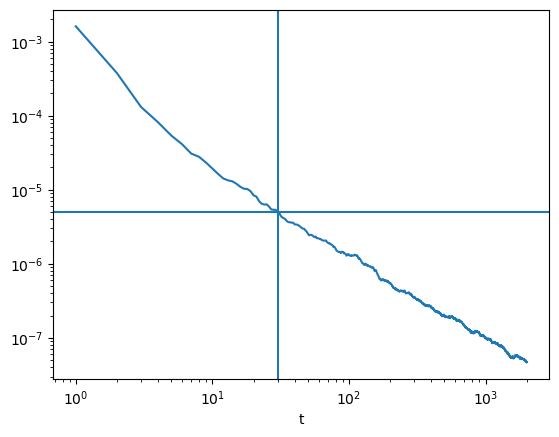

In [86]:
fig, ax = plt.subplots()
df_results.var(axis=1).plot(ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")
ax.axhline(5*10**-6)
ax.axvline(30)

In [25]:
probs_orig = prob_history_oob
num_trees_available = prob_history_oob.shape[0]
for permutation_seed in range(10):
    rs = np.random.RandomState(permutation_seed)
    permutation = rs.choice(range(num_trees_available), num_trees_available, replace=False)
    dist = None
    for t, tree_index in enumerate(permutation, start = 1):
        dist_tree = probs_orig[tree_index]
        if t == 1:
            dist = dist_tree
        else:
            dist = ((t - 1) * dist + dist_tree) / t

[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
